In [1]:
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# Keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

# Sk learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
import hdbscan
import numpy as np

import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator


# from gensim.models.doc2vec import Doc2Vec





Using TensorFlow backend.


In [4]:
stopWords = set(stopwords.words('english'))
pd.options.display.max_columns = None

In [5]:

import gensim
# google_model_path= 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
google_model_path = './GoogleNews-vectors-negative300.bin.gz'
# Load Google's pre-trained Word2Vec model.
# model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  
model = gensim.models.KeyedVectors.load_word2vec_format(google_model_path, binary=True, limit=10 ** 5)

In [6]:
df_original = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv')

In [7]:
df_original.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [8]:
df=df_original.copy(deep = True)
df=df.drop(columns = 'id')

In [9]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
regex_queries = [
#                 '@([A-Za-z0-9_]+)', #Usernames for twitter
#                'rt\s:\s', #Retweets marker
                 '(https?:\s?\/\s?\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?' # Hyperlinks
                ]

df['text'] = df['comment_text'].replace(regex_queries,'',regex = True)
# Remove symbols
df['text'].replace('[^\w\s]|_','', regex = True,inplace = True)

In [11]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['text_tokenized'] = df['text'].apply(lambda x: tokenization(x.lower()))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_tokenized
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re..."


In [12]:

def remove_stopwords(text):
    text = [word for word in text if word not in stopWords]
    return text
    
df['text_nonstop'] = df['text_tokenized'].apply(lambda x: remove_stopwords(x))

In [13]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text if len(word) < 30]  # the length restriction prevents  
                                                                # long strings from overflowing recursion used in stemmer
    return text

df['text_stemmed'] = df['text_nonstop'].apply(lambda x: stemming(x))


In [14]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text if len(word) < 30] 
    return text

df['text_lemmed'] = df['text_nonstop'].apply(lambda x: lemmatizer(x))
df.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_tokenized,text_nonstop,text_stemmed,text_lemmed
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[explan, edit, made, usernam, hardcor, metalli...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin...","[daww, match, background, colour, im, seemingl...","[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...","[hey, man, im, realli, tri, edit, war, guy, co...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions...","[, cant, make, real, suggestions, improvement,...","[, cant, make, real, suggest, improv, wonder, ...","[, cant, make, real, suggestion, improvement, ..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[sir, hero, chanc, rememb, page, that]","[sir, hero, chance, remember, page, thats]"


In [15]:
def vectorize_words(text):
        text = [model.get_vector(word) for word in text if word in model.vocab]
        
        return text
df['text_vectorized'] = df['text_lemmed'].apply(lambda x: vectorize_words(x))

In [16]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_tokenized,text_nonstop,text_stemmed,text_lemmed,text_vectorized
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[explan, edit, made, usernam, hardcor, metalli...","[explanation, edits, made, username, hardcore,...","[[-0.07080078, -0.3671875, -0.008972168, -0.07..."
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin...","[daww, match, background, colour, im, seemingl...","[daww, match, background, colour, im, seemingl...","[[-0.15527344, 0.025024414, 0.064941406, -0.12..."
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...","[hey, man, im, realli, tri, edit, war, guy, co...","[hey, man, im, really, trying, edit, war, guy,...","[[0.021606445, 0.021728516, 0.05029297, 0.3378..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions...","[, cant, make, real, suggestions, improvement,...","[, cant, make, real, suggest, improv, wonder, ...","[, cant, make, real, suggestion, improvement, ...","[[0.20410156, -0.030395508, 0.0006866455, 0.34..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[sir, hero, chanc, rememb, page, that]","[sir, hero, chance, remember, page, thats]","[[0.083496094, 0.045410156, 0.25, 0.47070312, ..."


In [17]:
df['num_words'] = df['text_lemmed'].apply(lambda x: len(x))

In [18]:
df.loc[df['num_words'] == df['num_words'].max()]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_tokenized,text_nonstop,text_stemmed,text_lemmed,text_vectorized,num_words
32143,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1,0,0,0,0,0,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,"[pig, pig, pig, pig, pig, pig, pig, pig, pig, ...","[pig, pig, pig, pig, pig, pig, pig, pig, pig, ...","[pig, pig, pig, pig, pig, pig, pig, pig, pig, ...","[pig, pig, pig, pig, pig, pig, pig, pig, pig, ...","[[-0.084472656, -0.07714844, -0.042236328, 0.2...",1250
61793,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOE...,0,0,0,0,0,0,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOE...,"[oh, noes, oh, noes, oh, noes, oh, noes, oh, n...","[oh, noes, oh, noes, oh, noes, oh, noes, oh, n...","[oh, noe, oh, noe, oh, noe, oh, noe, oh, noe, ...","[oh, no, oh, no, oh, no, oh, no, oh, no, oh, n...","[[0.07128906, 0.06933594, 0.075683594, 0.20800...",1250
76598,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,1,0,0,0,0,0,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,"[die, fag, die, fag, die, fag, die, fag, die, ...","[die, fag, die, fag, die, fag, die, fag, die, ...","[die, fag, die, fag, die, fag, die, fag, die, ...","[die, fag, die, fag, die, fag, die, fag, die, ...","[[0.100097656, 0.17578125, 0.043701172, 0.4062...",1250
150039,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,0,0,0,0,0,0,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,"[lol, lol, lol, lol, lol, lol, lol, lol, lol, ...","[lol, lol, lol, lol, lol, lol, lol, lol, lol, ...","[lol, lol, lol, lol, lol, lol, lol, lol, lol, ...","[lol, lol, lol, lol, lol, lol, lol, lol, lol, ...","[[-0.23535156, -0.049560547, 0.08203125, 0.341...",1250


(array([1.29559e+05, 1.92630e+04, 5.45500e+03, 1.98200e+03, 9.83000e+02,
        6.88000e+02, 5.63000e+02, 4.60000e+02, 4.11000e+02, 9.40000e+01]),
 array([  0. ,  49.9,  99.8, 149.7, 199.6, 249.5, 299.4, 349.3, 399.2,
        449.1, 499. ]),
 <a list of 10 Patch objects>)

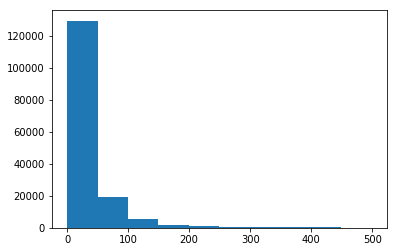

In [19]:
plt.hist(df['num_words'].loc[df['num_words'] < 500])

In [20]:
# def clean_text(text):
#     text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
#     text_rc = re.sub('[0-9]+', '', text_lc)
#     tokens = re.split('\W+', text_rc)    # tokenization
#     text = [ps.stem(word) for word in tokens if word not in stopWords and len(word) < 30]  # remove stopwords and stemming
#     return text
# countVectorizer = CountVectorizer(analyzer=clean_text) 
# countVector = countVectorizer.fit_transform(df['text'])
# print('{} Number of Tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())



NameError: name 'countVector' is not defined

In [ ]:
y_train = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

In [ ]:
X_train = pad_sequences(df['text_vectorized'], maxlen=500, value = 0.0)

In [21]:
X_train

NameError: name 'X_train' is not defined

In [ ]:
# pad each comment first up to 100, then flatten

In [ ]:
# # Model building



# NN = Sequential()
# # Node, input dimensions
# NN.add(Dense(100,  input_dim = X_train.shape)) # need feature input dim (28x28) for first hidden layer
# NN.add(Activation('relu'))

# NN.add(Dense(20))
# NN.add(Activation('relu'))

# NN.add(Dense(10)) # note we would typically use higher dim than this for last hidden layer
# NN.add(Activation('relu', name = '2D_layer')) # naming this layer so we can extract it later

# # Output layer

# NN.add(Dense(6))
# NN.add(Activation('sigmoid'))

# # NN.compile(loss='categorical_crossentropy', optimizer='adam')
# # For multi label (Classes are not mutually exclusive)
# NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# NN.fit(X_train, y_train, epochs=20, batch_size=512, verbose=1) # track progress as we fit

In [ ]:
# # Keras example code
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation
# from keras.layers import Embedding
# from keras.layers import Conv1D, GlobalMaxPooling1D
# from keras.datasets import imdb

# # set parameters:
# max_features = 5000
# maxlen = 400
# batch_size = 32
# embedding_dims = 50
# filters = 250
# kernel_size = 3
# hidden_dims = 250
# epochs = 2

# print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')

# print('Pad sequences (samples x time)')
# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# print('x_train shape:', x_train.shape)
# print('x_test shape:', x_test.shape)

# print('Build model...')
# model = Sequential()

# # we start off with an efficient embedding layer which maps
# # our vocab indices into embedding_dims dimensions
# model.add(Embedding(max_features,
#                     embedding_dims,
#                     input_length=maxlen))
# model.add(Dropout(0.2))

# # we add a Convolution1D, which will learn filters
# # word group filters of size filter_length:
# model.add(Conv1D(filters,
#                  kernel_size,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# # we use max pooling:
# model.add(GlobalMaxPooling1D())

# # We add a vanilla hidden layer:
# model.add(Dense(hidden_dims))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))

# # We project onto a single unit output layer, and squash it with a sigmoid:
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(x_test, y_test))

In [21]:
models = {}

In [22]:
models['toxic'] = 's'

In [23]:
models['toxic']

's'